In [2]:
import sys

sys.path.append('/workspace/siamesebert')


In [3]:
!pip install sentence_transformers


[notice] A new release of pip is available: 23.3.1 -> 24.1
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from utils.Evaluators import ContrastiveEvaluator, AaEvaluator
from sentence_transformers import models, SentenceTransformer
from sentence_transformers.readers import InputExample
from sentence_transformers.losses.BatchHardTripletLoss import BatchHardTripletLossDistanceFunction
from sentence_transformers.losses.ContrastiveLoss import SiameseDistanceMetric
from sentence_transformers.losses import BatchAllTripletLoss, BatchHardTripletLoss
from utils.Losses import ModifiedContrastiveLoss, MyContrastiveLoss

import wandb
import argparse
import os
import numpy as np
import random
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.DEBUG)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
def get_random_substring(txt, substr_len=512*5):
    if len(txt) > substr_len + 1:
        idx = random.randint(0, len(txt) - substr_len + 1)
        txt = txt[idx:idx + substr_len]
    return txt

In [83]:
class AVDataset(Dataset):
    def __init__(self, data):
        super(AVDataset, self).__init__()
        self.data = []
        self.raw_data = []
        for entry in data:
            self.data.append(InputExample(label=entry['score'], texts=[entry['text1'], entry['text2']]))
            self.raw_data.append([entry['score'], entry['text1'], entry['text2']])
        self.data_len = len(self.data)

    def __len__(self):
        return self.data_len

    def __getitem__(self, item):
        return self.data[item]

    def get_chunked(self, item):
        chunk_len = 256 * 5
        if isinstance(item, slice):
            samples = self.raw_data[item]
            chunked_samples = []
            for label, text0, text1 in samples:
                chunked_samples.append(self.break_sample_into_chunks(label, text0, text1, chunk_len))
            return chunked_samples
        else:
            label, text0, text1 = self.raw_data[item]
            return self.break_sample_into_chunks(label, text0, text1, chunk_len)

    @staticmethod
    def break_sample_into_chunks(lbl, txt0, txt1, chunk_len, max_txt_len=100000):
        txt0 = txt0[:max_txt_len]
        txt1 = txt1[:max_txt_len]
        chunked = []
        min_len = min(len(txt0), len(txt1))
        for i in range(0, min_len, chunk_len):
            chunked.append(InputExample(label=lbl, texts=[txt0[i:i + chunk_len], txt1[i:i + chunk_len]]))
        return chunked


In [7]:
!pip install wandb


[notice] A new release of pip is available: 23.3.1 -> 24.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import wandb
wandb.login()


DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:8888
DEBUG:urllib3.connectionpool:http://localhost:8888 "GET /api/sessions?token=k50d39iydnxe69o16x6v HTTP/1.1" 200 840
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
wandb: Currently logged in as: swan-07 (swan07). Use `wandb login --relogin` to force relogin


True

In [9]:
print(wandb.__path__)

['/usr/local/lib/python3.10/dist-packages/wandb']


In [10]:
# wandb.init(project='test', config={})
# run_name = wandb.run.name(id="xoorffmm", resume="must")
wandb.init(project='test', config={}, resume='must', id="a4t3eu8g")

In [11]:
run_name = wandb.run.name
run_id = wandb.run.id  # Get the run ID for resuming later if needed

# Save the run ID for future use
print(f"Run name: {run_name}")
print(f"Run ID: {run_id}")

Run name: morning-lake-5
Run ID: a4t3eu8g


In [12]:
!pip install datasets


[notice] A new release of pip is available: 23.3.1 -> 24.1
[notice] To update, run: python -m pip install --upgrade pip


In [13]:
import pickle
with open('/workspace/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [14]:
with open('/workspace/val.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [15]:
from huggingface_hub import HfApi, login
api = HfApi()
login()

In [16]:
from datasets import load_dataset

In [ ]:
train_dataset = load_dataset("swan07/authorship-verification", data_files="*_train.csv", download_mode="force_redownload")
val_dataset = load_dataset("swan07/authorship-verification", data_files="*_val.csv", download_mode="force_redownload")

In [18]:
train_data = train_dataset['train']

In [19]:
test_data = val_dataset['train']

In [20]:
test_data = test_data.rename_column('same', 'score')
train_data = train_data.rename_column('same', 'score')


In [21]:
with open('val.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [22]:
with open('train.pkl', 'wb') as f:
    pickle.dump(train_data, f)

In [23]:
test_dataset = AVDataset(test_data)

In [24]:
train_dataset = AVDataset(train_data)

In [25]:
model_path = 'bert-base-cased'
dropout = 0.1
max_seq_len = 512

word_embedding_model = models.Transformer(model_path, max_seq_length=max_seq_len)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_cls_token=True,
                               pooling_mode_mean_tokens=True,
                               pooling_mode_max_tokens=True)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(),
                           out_features=256,
                           activation_function=nn.ReLU())
# model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], device='cuda')

# logging.debug('model info:')
# logging.debug(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


In [69]:
import os
import re

# Directory where checkpoints are stored
checkpoint_dir =  "/workspace/siamesebert/methods/SiameseBert_output/morning-lake-5"

# Regex pattern to match checkpoint filenames
checkpoint_pattern = re.compile(r'checkpoint-(\d+)')

# Get a list of all checkpoint files
checkpoints = [f for f in os.listdir(checkpoint_dir) if checkpoint_pattern.match(f)]

# Sort checkpoints by step number
checkpoints.sort(key=lambda x: int(checkpoint_pattern.match(x).group(1)))

# Keep the last two checkpoints
checkpoint_last = checkpoints[-1]

checkpoint_path = os.path.join(checkpoint_dir, checkpoint_last)
print(f'{checkpoint_path}')


/workspace/siamesebert/methods/SiameseBert_output/morning-lake-5/checkpoint-180000


In [70]:

# Define the path to the checkpoint
# checkpoint_path = "/workspace/siamesebert/methods/SiameseBert_output/morning-lake-5/checkpoint-39000"

model = SentenceTransformer(checkpoint_path)

# Ensure the model is in evaluation mode
# model.eval()

# # Use the model for inference
# input_texts = ["Sample text for model inference"]
# embeddings = model.encode(input_texts, convert_to_tensor=True)

# print(embeddings)


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: /workspace/siamesebert/methods/SiameseBert_output/morning-lake-5/checkpoint-180000


In [28]:
distance_metric = 'euclidean'
batch_size = 2

if distance_metric == 'euclidean':
    contrastive_dist_metric = SiameseDistanceMetric.EUCLIDEAN
    triplet_dist_metric = BatchHardTripletLossDistanceFunction.eucledian_distance
elif distance_metric == 'cosine':
    contrastive_dist_metric = SiameseDistanceMetric.COSINE_DISTANCE
    triplet_dist_metric = BatchHardTripletLossDistanceFunction.cosine_distance
else:
    raise ValueError(f'{distance_metric} is not defined')

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [81]:
def get_random_sample(dataset, fraction=0.01):
    sample_size = max(1, int(len(dataset) * fraction))  # Ensure at least one item is sampled
    sample_indices = random.sample(range(len(dataset)), sample_size)
    return [dataset[i] for i in sample_indices]

# Assuming test_dataset is a list or similar iterable
sampled_test_dataset = get_random_sample(test_data)

In [93]:
sampled_train_dataset = get_random_sample(train_data, fraction=0.001)

In [50]:
type(sampled_test_dataset[0])

dict

In [84]:
sampled_test_dataset = AVDataset(sampled_test_dataset)

In [94]:
sampled_train_dataset = AVDataset(sampled_train_dataset)

In [95]:
sampled_train_dataloader = DataLoader(sampled_train_dataset, shuffle=True, batch_size=batch_size)

In [85]:
sampled_test_dataloader = DataLoader(sampled_test_dataset, shuffle=True, batch_size=batch_size)

In [32]:
# kernel_fn = lambda x: -x

# evaluator = ContrastiveEvaluator(test_dataset,
#                                  batch_size=batch_size,
#                                  distance_metric=contrastive_dist_metric,
#                                  triplet_dist_metric=triplet_dist_metric,
#                                  kernel_fn=kernel_fn,
#                                  post_eval_callable=None)
import random

# Function to create a random sample of 1/1000th of the dataset


# Define your kernel function and other parameters
kernel_fn = lambda x: -x

# Create the evaluator with the sampled dataset
evaluator = ContrastiveEvaluator(sampled_test_dataset,
                                 batch_size=batch_size,
                                 distance_metric=contrastive_dist_metric,
                                 triplet_dist_metric=triplet_dist_metric,
                                 kernel_fn=kernel_fn,
                                 post_eval_callable=None)
evaluator.primary_metric = 'accuracy'  # Set the primary metric to a valid string


In [87]:
type(evaluator)

utils.Evaluators.ContrastiveEvaluator

In [33]:
which_loss_fn = 'ModifiedContrastiveLoss'
margin = 0.5
diff_margin = 0.09
same_margin = 0.91

if which_loss_fn == 'ContrastiveLoss':
    train_loss = MyContrastiveLoss(model=model, distance_metric=contrastive_dist_metric,
                                   margin=margin, kernel_fn=kernel_fn)
elif which_loss_fn == 'ModifiedContrastiveLoss':
    train_loss = ModifiedContrastiveLoss(model=model, distance_metric=contrastive_dist_metric,
                                         different_margin=diff_margin,
                                         same_margin=same_margin,
                                         kernel_fn=kernel_fn)
elif which_loss_fn == 'AllTriplet':
    train_loss = BatchAllTripletLoss(model=model, distance_metric=triplet_dist_metric, margin=margin)
elif which_loss_fn == 'BatchHardTriplet':
    train_loss = BatchHardTripletLoss(model=model, distance_metric=triplet_dist_metric, margin=margin)
else:
    raise ValueError('The selected loss function is not recognized.')

In [34]:
epochs = 5
scheduler = 'warmuplinear'
warmup_steps = 0
lr = 2e-5
eps = 1e-6
correct_bias = True
checkpoint_save_steps = 10000  # Save checkpoint every 1000 steps
output_path = os.path.join('SiameseBert_output', run_name)


In [96]:

model.fit(train_objectives=[(sampled_train_dataloader, train_loss)],
          epochs=epochs,
          scheduler=scheduler,
          warmup_steps=warmup_steps,
          save_best_model=True,
          output_path=output_path,
          evaluator=evaluator,
          evaluation_steps=500,
          checkpoint_path=output_path,  # Path to save the checkpoint
          checkpoint_save_steps=checkpoint_save_steps,  # Frequency of saving checkpoints
          optimizer_params={'lr': lr, 'eps': eps},
         )


Step,Training Loss,Validation Loss,Evaluator
163,No log,No log,0.524430
326,No log,No log,0.524430
489,No log,No log,0.524430
500,0.433100,No log,0.524430
652,0.433100,No log,0.524430
815,0.433100,No log,0.524430


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188
INFO:sentence_transformers.SentenceTransformer:Save model to SiameseBert_output/morning-lake-5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:CustomEvaluator - Accuracy: 0.5244299674267101
INFO:root:CustomEvaluator - Precision: 0.5244299674267101
INFO:root:CustomEvaluator - Recall: 1.0
INFO:root:CustomEvaluator - F1 Score: 0.688034188034188


In [ ]:
with open('/workspace/test.pkl', 'rb') as f:
    test_datas = pickle.load(f)

In [100]:
model.save('bertmodel')

INFO:sentence_transformers.SentenceTransformer:Save model to bertmodel


In [91]:
from sentence_transformers import SentenceTransformer, LoggingHandler, evaluation
from sentence_transformers.evaluation import SentenceEvaluator
import logging
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class CustomEvaluator(SentenceEvaluator):
    def __init__(self, dataloader, name, threshold=0.5):
        self.dataloader = dataloader
        self.name = name
        self.threshold = threshold

    def __call__(self, model, output_path='eval', epoch=-1, steps=-1):
        model.eval()
        all_labels = []
        all_scores = []

        with torch.no_grad():
            for batch in self.dataloader:
                texts1, texts2, labels = batch
                embeddings1 = model.encode(texts1, convert_to_tensor=True)
                embeddings2 = model.encode(texts2, convert_to_tensor=True)
                scores = [util.pytorch_cos_sim(e1, e2).item() for e1, e2 in zip(embeddings1, embeddings2)]

                all_labels.extend(labels.numpy())  # Convert labels to numpy and extend the list
                all_scores.extend(scores)

        # Convert to numpy arrays for evaluation
        all_labels = np.array(all_labels)
        all_scores = np.array(all_scores)

        # Binarize the scores based on the threshold
        predictions = (all_scores >= self.threshold).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, predictions)
        precision = precision_recall_fscore_support(all_labels, predictions, average='binary')[0]
        recall = precision_recall_fscore_support(all_labels, predictions, average='binary')[1]
        f1 = precision_recall_fscore_support(all_labels, predictions, average='binary')[2]

        logging.info(f"{self.name} - Accuracy: {accuracy}")
        logging.info(f"{self.name} - Precision: {precision}")
        logging.info(f"{self.name} - Recall: {recall}")
        logging.info(f"{self.name} - F1 Score: {f1}")

        return accuracy

# Create the custom evaluator
evaluator = CustomEvaluator(dataloader=train_loader, name="CustomEvaluator")


In [53]:
from sentence_transformers import SentenceTransformer, util
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# # Load the trained SentenceTransformer model
# model_path = '/path/to/your/checkpoint-180000'  # Replace with your actual model path
# model = SentenceTransformer(model_path)

# Assuming you have your training data in a variable called `train_data`
# Example: train_data = [{'text1': '...', 'text2': '...', 'score': 0}, ...]

class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text1 = self.data[idx]['text1']
        text2 = self.data[idx]['text2']
        label = self.data[idx]['score']
        return text1, text2, label

# Create the dataset and DataLoader
train_dataset = TextDataset(sampled_test_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in data_loader:
            texts1, texts2, labels = zip(*batch)
            embeddings1 = model.encode(texts1, convert_to_tensor=True)
            embeddings2 = model.encode(texts2, convert_to_tensor=True)
            scores = [util.pytorch_cos_sim(e1, e2).item() for e1, e2 in zip(embeddings1, embeddings2)]

            all_labels.extend(labels)
            all_scores.extend(scores)

    # Convert to numpy arrays for evaluation
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # Binarize the scores based on a threshold
    threshold = 0.5
    predictions = (all_scores >= threshold).astype(int)

    return predictions, all_labels

# Evaluate the model on the training set
predictions, true_labels = evaluate(model, train_loader)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


ValueError: too many values to unpack (expected 3)

In [77]:
from torch.utils.data import DataLoader

# Create the dataset and DataLoader
train_dataset = TextDataset(sampled_test_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in data_loader:
            texts1, texts2, labels = batch
            embeddings1 = model.encode(list(texts1), convert_to_tensor=True)
            embeddings2 = model.encode(list(texts2), convert_to_tensor=True)
            scores = [util.pytorch_cos_sim(e1, e2).item() for e1, e2 in zip(embeddings1, embeddings2)]

            all_labels.extend(labels)
            all_scores.extend(scores)

    # Convert to numpy arrays for evaluation
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # Binarize the scores based on a threshold
    threshold = 0.5
    predictions = (all_scores >= threshold).astype(int)

    return predictions, all_labels, all_scores


# Evaluate the model on the training set
predictions, true_labels, all_scores = evaluate(model, train_loader)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 0.5244299674267101
Precision: 0.5244299674267101
Recall: 1.0
F1 Score: 0.688034188034188


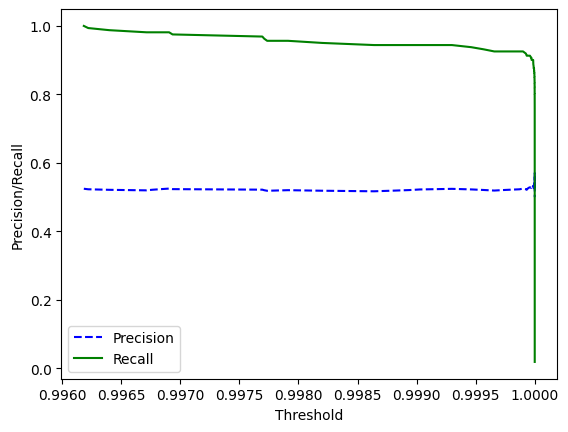

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, all_scores)

# Plot the precision-recall curve
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='best')
plt.show()


In [101]:
test_data_files = {
    "arxiv": "arxiv_test.csv",
    "blogs": "blogs_test.csv",
    "british": "british_test.csv",
    "darkreddit": "darkreddit_test.csv",
    "imdb": "imdb_test.csv",
    "pan11": "pan11_test.csv",
    "pan13": "pan13_test.csv",
    "pan14": "pan14_test.csv",
    "pan15": "pan15_test.csv",
    "pan20": "pan20_test.csv",
    "reuters": "reuters_test.csv",
    "victorian": "victorian_test.csv",
}

In [ ]:
test_datasets = {name: load_dataset('swan07/authorship-verification', data_files={"test": file}, split='test') for name, file in test_data_files.items()}

In [104]:
test_datasets

{'arxiv': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 106
 }),
 'blogs': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 8840
 }),
 'british': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 173
 }),
 'darkreddit': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 412
 }),
 'imdb': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 4648
 }),
 'pan11': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 698
 }),
 'pan13': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 18
 }),
 'pan14': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 400
 }),
 'pan15': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 200
 }),
 'pan20': Dataset({
     features: ['same', 'text1', 'text2'],
     num_rows: 13704
 }),
 'reuters': Dataset({
     features: ['text1', 'text2', 'same'],
     num_rows: 181
 }),
 'victorian': Dataset({
     fea

In [111]:
with open('/workspace/testdsets.pickle', 'wb') as f:
    pickle.dump(test_datasets, f)

In [106]:
import torch
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text1 = self.data[idx]['text1']
        text2 = self.data[idx]['text2']
        label = self.data[idx]['same']
        return text1, text2, torch.tensor(label, dtype=torch.float32)

# Define the evaluation function
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            texts1, texts2, labels = batch
            embeddings1 = model.encode(texts1, convert_to_tensor=True, show_progress_bar=False)
            embeddings2 = model.encode(texts2, convert_to_tensor=True, show_progress_bar=False)
            scores = [util.pytorch_cos_sim(e1, e2).item() for e1, e2 in zip(embeddings1, embeddings2)]

            all_labels.extend(labels.numpy())  # Convert labels to numpy and extend the list
            all_scores.extend(scores)

    # Convert to numpy arrays for evaluation
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # Binarize the scores based on the threshold
    predictions = (all_scores >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predictions, average='binary')

    return accuracy, precision, recall, f1

# Example datasets
datasets = test_datasets

# Convert each dataset into a TextDataset and DataLoader
for name, dataset in datasets.items():
    text_dataset = TextDataset(dataset)
    dataloader = DataLoader(text_dataset, batch_size=16, shuffle=False)
    
    # # Load your model
    # model_path = '/path/to/your/model'  # Replace with your actual model path
    # model = SentenceTransformer(model_path)
    
    # Evaluate the model on the current dataset
    accuracy, precision, recall, f1 = evaluate_model(model, dataloader)
    
    # Print the metrics
    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("-" + "-"*20 + "-")


Metrics for arxiv:
Accuracy: 0.5660377358490566
Precision: 0.5660377358490566
Recall: 1.0
F1 Score: 0.7228915662650602
----------------------
Metrics for blogs:
Accuracy: 0.4979638009049774
Precision: 0.4979638009049774
Recall: 1.0
F1 Score: 0.6648542516236218
----------------------
Metrics for british:
Accuracy: 0.5664739884393064
Precision: 0.5664739884393064
Recall: 1.0
F1 Score: 0.7232472324723247
----------------------
Metrics for darkreddit:
Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
----------------------
Metrics for imdb:
Accuracy: 0.4978485370051635
Precision: 0.4978485370051635
Recall: 1.0
F1 Score: 0.6647515081873026
----------------------
Metrics for pan11:
Accuracy: 0.5243553008595988
Precision: 0.5243553008595988
Recall: 1.0
F1 Score: 0.6879699248120301
----------------------
Metrics for pan13:
Accuracy: 0.4444444444444444
Precision: 0.4444444444444444
Recall: 1.0
F1 Score: 0.6153846153846154
----------------------
Metrics for pan14:
Accuracy: 0